#  **ICT303 - Assignment 2**

**Your name: <enter here your full name>**

**Student ID: <enter here your student ID>** 

**Email: <enter here your email address>** 

In this assignment, you will build a deep learning model for identifying $120$ different breeds of dogs. Similar to the previous assignment, you will use real images from the [Kaggle competition](https://www.kaggle.com/c/dog-breed-identification). 

In this assignment, your are required to use a ResNet network. You can use ResNet implementation provided in PyTorch. Note however  that there are many versions of ResNet (they differ in terms of number of layers). Your task is to find the best configuration that gives the best performance. 

The rule is similar to the previous assignment:

1. Develop a better model to reduce the recognition error.  
2. Submit your results to Kaggle and take a sceenshot of your score. Then insert here the screenshot of your result. 

It is important that you start as earlier as possible. Tuning hyper-parameters takes time, and Kaggle limits the number of submissions per day.

The top 3 students in the Kaggle ranking will be invited for a coffee!

## **0. Pre-requisites**



Import all relevant libraries for use

In [2]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

Checks to see if CUDA GPUs are available. They are more effective in computational runs for this assignment

In [3]:
# Use cuda if possible (computationally more effective than cpu)
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

device_count = torch.cuda.device_count()
print("Number of available GPUs:", device_count)

Using cpu.
Number of available GPUs: 0


## **1. Obtaining and Organizing the Data Set**

The competition data is divided into a training set and testing set:
- The training set contains $10,222$ color images.
- The testing set contains $10,357$ color images. 

The images in both sets are in JPEG format. Each image contains three channels (R, G and B). The images have  different heights and widths.

There are $120$ breeds of dogs in the training set, e.g., *Labradors, Poodles, Dachshunds,
Samoyeds, Huskies, Chihuahuas, and Yorkshire Terriers*.

### **1.1. Directory of Data Set**

Download the data from the [Kaggle competition](https://www.kaggle.com/competitions/dog-breed-identification/data). Then extract the data to where you want it. The subdirectory of where this notebook is recommended to make things simple.

Change below to the path where the data is located then run.

For example, if the data is on a subdirectory of the current folder called DataFolder then change it to './DataFolder'.

In [4]:
data_dir = '../MLData-dog-breed-image-recognition'

Doing it in google colab takes too long (4 hours on my end!). Unless you have access to the A100/V100 GPU that google provides, it is better to do it offline. Below is the code for running the notebook on google colab:


In [ ]:
import importlib

def is_running_in_colab():
    try:
        from google.colab import _ipython as ip
        return True
    except ImportError:
        return False

try:
  if is_running_in_colab():
    print("Running in Google Colab")
    from google.colab import drive
    drive.mount('/content/gdrive',force_remount=True)
  else:
    print("Running in Jupyter or VSCode")

  import requests
  url = 'https://raw.githubusercontent.com/joccing/ICT303-assignment2/master/config.py'

  headers = {
    'Cache-Control': 'no-cache',
    'Pragma': 'no-cache',
    }

  r = requests.get(url, allow_redirects=True, headers=headers)
  open('config.py', 'wb').write(r.content)

except ModuleNotFoundError:
  pass

# PLEASE MODIFY BASE PATH
BASE_PATH = F"/content/gdrive/My Drive/ICT303A2"
# Name of zip files
zipfiles = ['dog-breed-identification.zip']

from config import *
importlib.reload(sys.modules['config'])
from config import *

DOWNLOADED = config_data(BASE_PATH,zipfiles, ['train','test','labels.csv'])
assert DOWNLOADED == 20581 or DOWNLOADED < 0
assert check_all(BASE_PATH, ['train','test','labels.csv']) == True

data_dir = BASE_PATH

### **1.2. Organizing the Data Set**

Next, we define the reorg_train_valid function to split the validation set from the original Kaggle competition training set. The parameter valid_ratio in this function is the ratio of the number of examples of each dog breeds in the validation set to the number of examples of the
breed with the least examples (66) in the original training set. 

After organizing the data, images of the same breed will be placed in the same folder so that we can read them later.

In [7]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)


batch_size = 64 #if demo else 128
valid_ratio = 0.05
reorg_dog_data(data_dir, valid_ratio)

The `reorg_dog_data` function below is used to read the training data labels, segment the validation set, and organize the training set.

During actual training and testing, we would use the entire Kaggle Competition data set and call the reorg_dog_data function to organize the data set. Likewise, we would need to set the batch_size to a larger integer, such as 128.

## **2. Image Augmentation**

Images in training set are augmented to provide more data and hopefully enchances the model's performance. Here's some reasoning and thoughts for the method chosen:

1. `Resize((256, 256))`: Resizes every image to be 256x256 pixels. Should ensure uniformity in image sizes.

2. `RandomHorizontalFlip()`: This function flips the image horizontally with 50% probability. This includes left-right mirrored versions of the images and should help increase the diversity of the dog poses that the model sees.

3. `RandomRotation(15)`: Randomly rotates image clockwise or counter-clockwise by up to 15 degrees. Not a lot of changes but it should allow the model to learn and recognize dog breeds even if they are slightly tilted in the image.

4. `CenterCrop(224)`: After augmentation, deterministic center crop is applied to obtain an image of size 224x224.

In [8]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Other methods of augmentation are considered but ultimately not used due to various reasons:

1. `RandomVerticalFlip()`: Flip image vertically. Dogs are typically upright creatures; a vertical flip would result in unrealistic images, because a photo of a dog upside-down is rare, and may confuse the model.

2. `RandomPerspective()`: Applies a random perspective transformation. The perspective of the image (the angle from which the photo was taken) is generally consistent and doesn't vary too drastically in the dataset so its not used.

3. `RandomGrayscale()`: Converts image to grayscale with a certain probability. This was not chosen because color is a significant feature in identifying dog breeds. Dogs are not commonly photographed in black and white, so there's little advantage in the model learning from grayscale images.

4. `RandomErasing()`: Randomly selects a square region in the image and erases its pixels. Not chosen because the erased area could remove key features of a dog (like its face or tail). 

5. `RandomResizedCrop()`: A random crop could sometimes be too aggressive and cut out important parts of the dog.

In [10]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

For test images, only simple resizing, center cropping, tensor conversion, and normalization are used, because during testing we don't want any randomness or augmentation. We only want to see how the model performs on the original untouched images.

Both `torchvision.transforms.ToTensor()` and `torchvision.transforms.Normalize()` in both cells are for converting the image to a tensor, and normalizing the RGB channels of the image to have mean and standard deviation.

## **3. Loading (Reading) the Data Set**

The following creates dataset from the directory and augment the images.

Specifically `train_ds` and `train_valid_ds` hold the training and combined training and validation data, taken from the `train` and `train_valid` folders. `transform_train` then augment the data based on the parameters set on the previous section.

Then `valid_ds` and `test_ds` hold the validation and testing data, from the `valid` and `test` folders. `transform_test` does the same and transform the data but with different parameters suited for dataset meant for testing.

In [11]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

The following wraps an iterable around the the dataset which allows batching, shuffle, and loading data in parallel.

   - `train_iter` and `train_valid_iter` create DataLoader instances for training and combined training-validation datasets respectively with specified `batch_size`, shuffling enabled and dropping the last incomplete batch.
   - `valid_iter` creates a DataLoader instance for the validation dataset, without shuffling (since order is irrelevant during validation), and drops the last incomplete batch.
   - `test_iter` creates a DataLoader instance for the test dataset without shuffling and does not drop the last incomplete batch (even a single sample would be predicted).

In [12]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

## **4. Defining and Training ResNet**

### **4.1. Loss and Train function**

Below is the loss functions

1. The Cross-Entropy loss being initialized for multi-class classification tasks. Remember that the dog breed identification will have 120 classes which cross-entropy works well with.

2. `evaluate_loss` function which computes the average loss over a given data iterator (either a training or validation iterator) for a given network and on specified devices (GPU/CPU).

Mean Squared Error loss and Binary Cross-Entropy Loss are not considered as both are used for regression problems or binary classification problems respectively.

Multi-Label Soft Margin Loss is considered but not chosen as it is more suited when each example can belong to more than one class. However for this model, an image can only contain 1 dog breed.

In [13]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        if len(devices) > 0:
            features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return l_sum / n

Below is the `train` function

It represents the main training loop which trains the network for a specified number of epochs with the given learning rate, weight decay, learning rate decay and learning rate period for decay. The Animator object is used to create a real-time plot of the loss as the training progresses.

1. Firstly, it checks if there are any devices available for parallel computation. If there are, it wraps the network into the `nn.DataParallel` object to take advantage of multiple GPUs.

2. Optimizer is then defined using Stochastic Gradient Descent (SGD), for only those parameters of the network that require gradients. It also setups a step learning rate scheduler that will decay the learning rate after every `lr_period` epochs.

3. Within the loop, it processes each batch of data from the training iterator, calculates loss and backpropagates the gradients, before updating the model's parameters. 

4. It optionally includes a validation dataset and calculates the validation loss after each epoch and adds it to the plot.

5. Finally, for every epoch, it prints the training and validation losses, the speed of the training in terms of examples per second, and the devices the training was performed on. 



In [14]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    
    if len(devices) > 0:
        net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD((param for param in net.parameters()
                               if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay=wd)
    
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']

    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            if len(devices) > 0:
                features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
        
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'

    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

### **4.2. The ResNet Model**

The model used for the final submission uses a ResNet-50, an Adam optimizer, only 2 layers for the output network, no dropout, and very small weight decay. Here's a more thorough explanation:

1. `get_net(devices)`: This function is used to create the model architecture. The pretrained ResNet50 model is used here as the base model. 

2. `for param in finetune_net.parameters(): param.requires_grad = False`: The parameters of the ResNet50 model are frozen that means the weights of these layers will not be updated during training.

3. `finetune_net.fc = nn.Sequential(...`: This block of code is used to replace the final fully connected layer of the ResNet50 model. The replaced layer will be trained from scratch with the random initial weights. The first linear layer takes the in_features from the previous fully-connected layer as input and outputs 512 features, introducing a ReLU activation function in between, and finally, a linear layer is added to output 120 different classes (breed of dogs).

4. `if devices: finetune_net = finetune_net.to(devices[0])`: This part will move the model definition to the first device on the list of the provided devices.

5. The model is then created using the `get_net(devices)` function. 

6. `optimizer = torch.optim.Adam(net.parameters(), lr=lr)`: The Adam optimizer is used for training the weights of the model. The learning rate (lr) is set to be 3e-4.

7. `devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 3e-4, 1e-6`: All available GPUs are being used for model training. The model is set to train for 10 epochs, learing rate at 3e-4 and the weight decay (wd) is set to 1e-6. 

8. `train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)`: Lastly, the model is trained using the training dataset (train_iter), validating with the validation dataset (valid_iter) with certain hyperparameters such as number of epochs (num_epochs), learning rate (lr), weight decay (wd), learning rate period (lr_period), and learning rate decay (lr_decay). The model is trained on the mentioned devices.

This configuration results in a training loss of 0.408 and a validation loss of 0.946. Much better than other configurations tested. To read further and see what other settings are tested, jump to section 6. 

train loss 0.408, valid loss 0.946
15.7 examples/sec on []


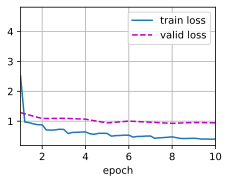

In [21]:
def get_net(devices):
    finetune_net = torchvision.models.resnet50(pretrained=True)  # Use ResNet50
    for param in finetune_net.parameters():
        param.requires_grad = False  # freeze all ResNet layers

    # Custom layers
    finetune_net.fc = nn.Sequential(
        nn.Linear(finetune_net.fc.in_features, 512),
        nn.ReLU(),
        nn.Linear(512, 120)
    )
    
    # Move the model to devices if devices is not empty
    if devices:
        finetune_net = finetune_net.to(devices[0])
    return finetune_net

# Create the model
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 3e-4, 1e-6
net = get_net(devices)

# Use Adam optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Keep the previous parameters
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 3e-4, 1e-6
lr_period, lr_decay, net = 1e-6, 1e-6, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

## **5. Run on the Testing Set and Submit the Results on Kaggle**

Score on Kaggle is 0.62922. Screenshots provided below. If screenshot is unavailable or corrupted, download the [submission.csv](https://drive.google.com/file/d/1DCgaZbBA1tzAULcxaDtuNLQ0hF3VOrTf/view?usp=drive_link) here and upload it to the kaggle competition.

Alternatively, screenshot is also on a temporary [imgur](https://i.imgur.com/5BVGLfL.png) link.

train loss 0.410
12.3 examples/sec on []


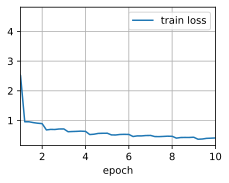

In [22]:
net = get_net(devices)
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    if len(devices) > 0:
        data = data.to(devices[0])
    output = torch.nn.functional.softmax(net(data), dim=1)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(
    os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')

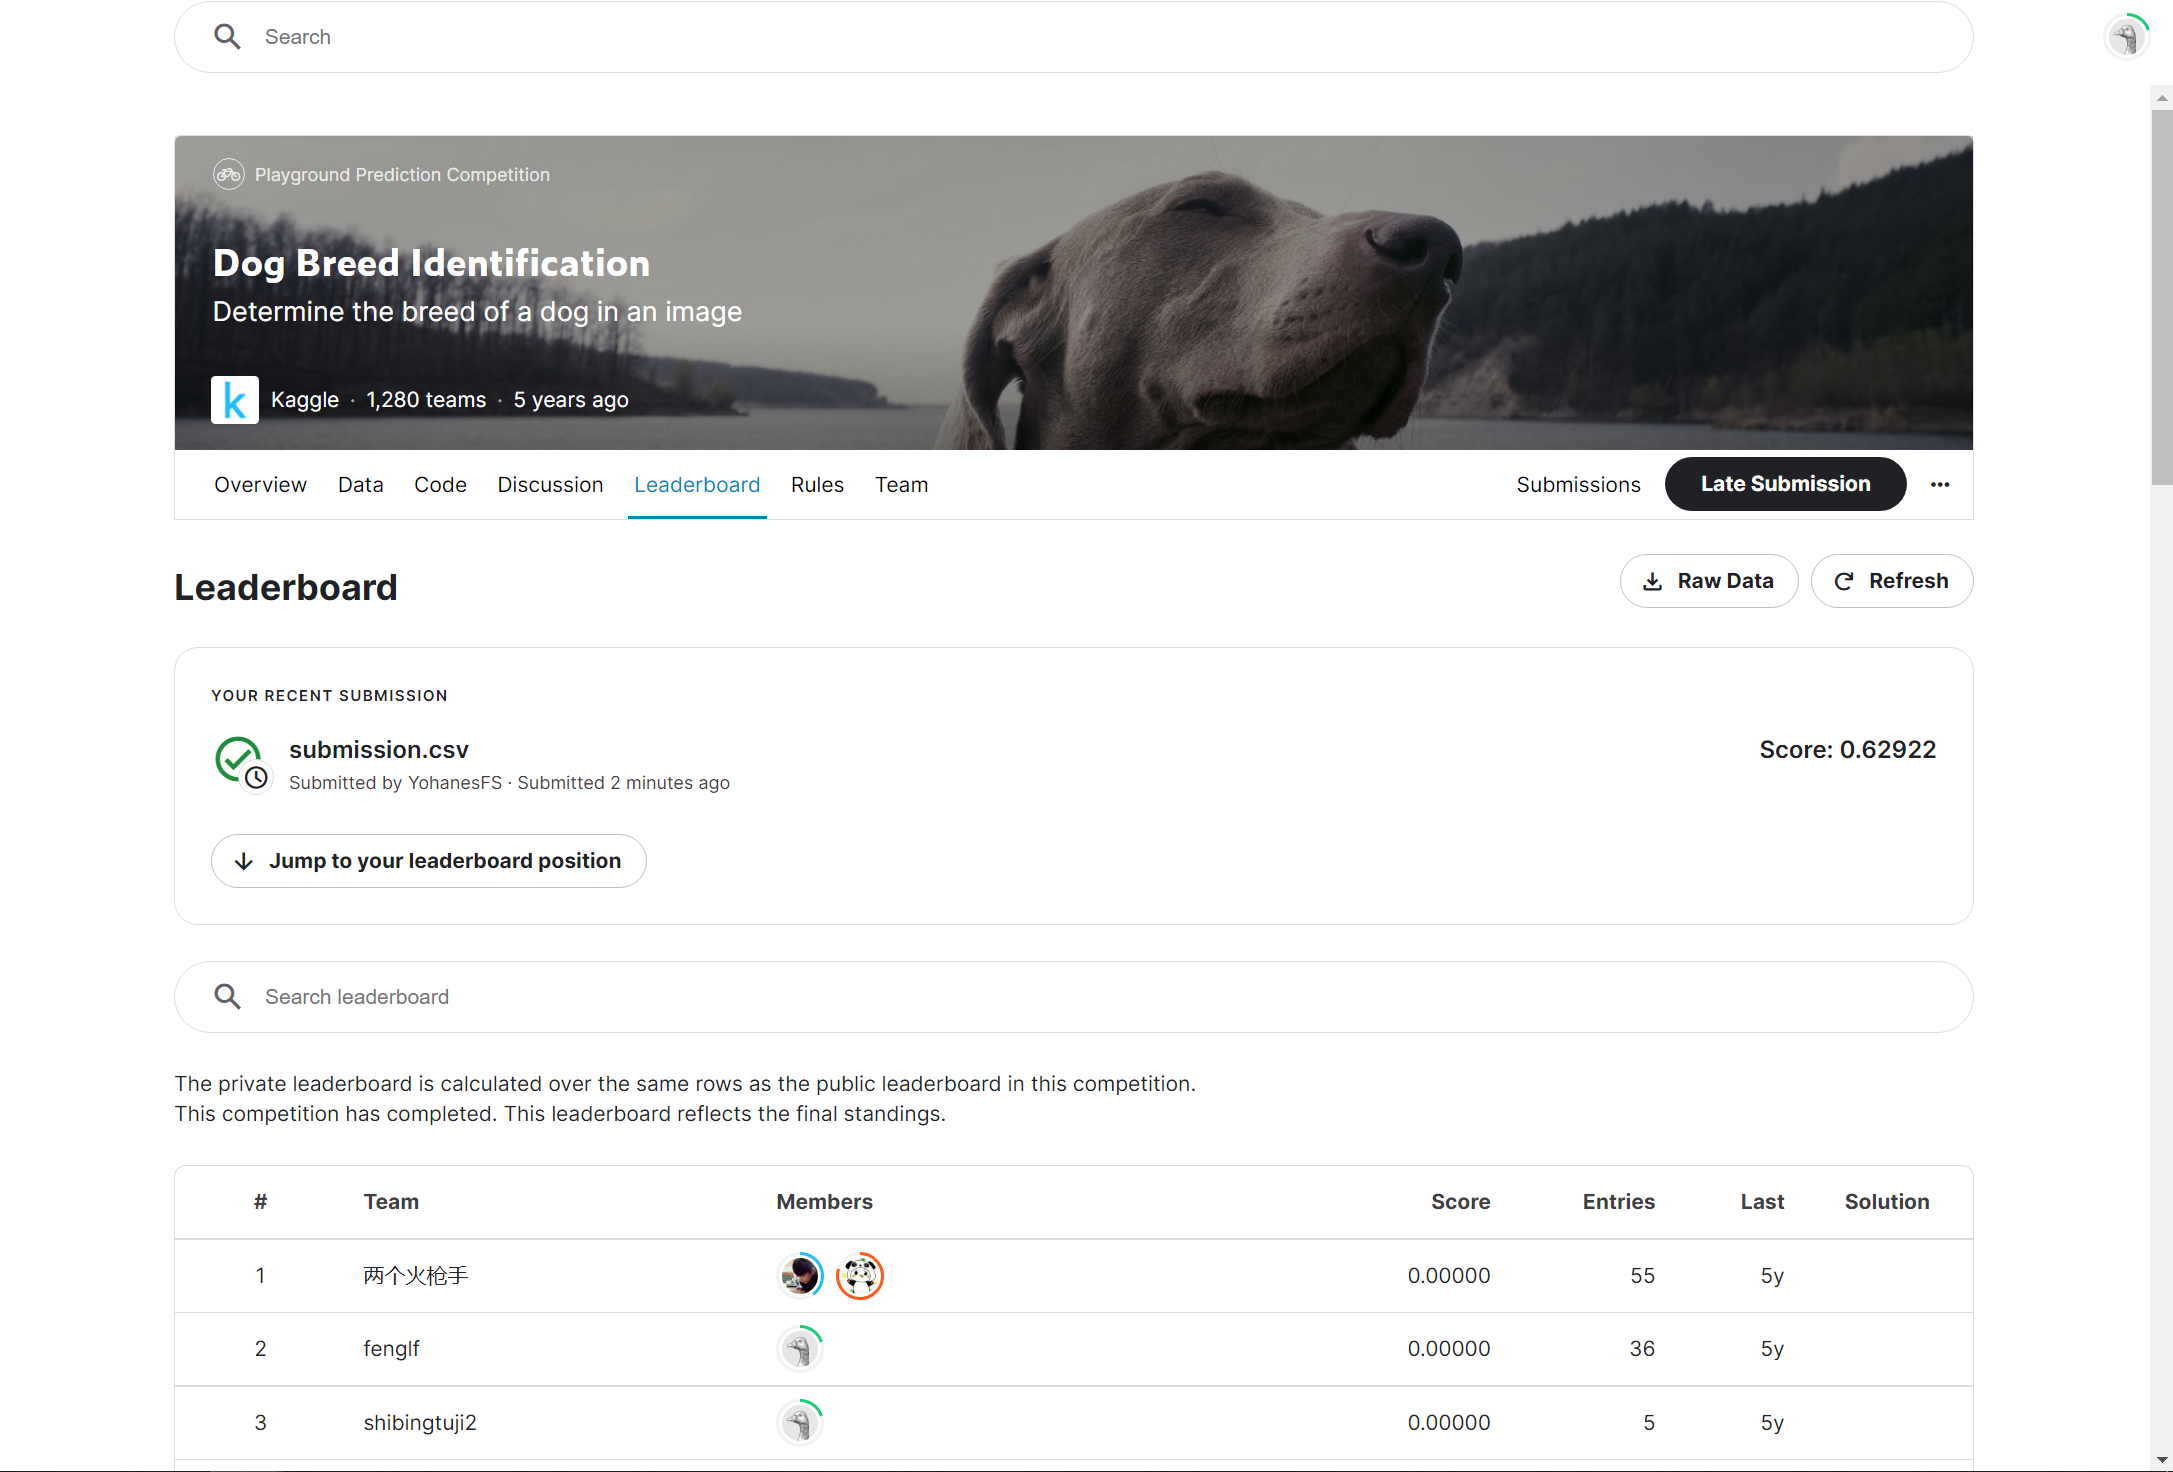

## **6. Other ResNet configuration tested**

### **6.1. Configuration #1**

The following is the original ResNet configuration as seen in the [d2l.ai website](https://d2l.ai/chapter_computer-vision/kaggle-dog.html). 

It uses a pretrained ResNet-34 model done on the ImageNet dataset. ImageNet dataset is an image database that is used for training and computer vision models. It contains millions of labeled images on thousands of categories, and is often used as a benchmark for image classification tasks. Here are some features:

1. The function defines a new output network to replace the original output layer of the ResNet model. This new network consists of two linear layers with ReLU activation in between. The final layer has 120 output categories (the number of dog breeds in our case).

2. If any devices (like GPUs) have been passed, it moves the model over to the specified device.

3. The function then freezes the parameters of the features network (which is the pre-trained ResNet34). This means only the last few fully connected layers (which were replaced) will have trainable parameters which significantly speeds up training and requires less data.

The result is a train train loss 0.444, valid loss 1.803. The high valid loss indicates the data is overfitting.

train loss 0.444, valid loss 1.803
28.7 examples/sec on []


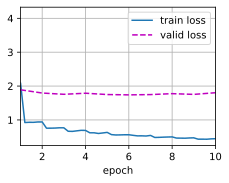

In [15]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    # Define a new output network (there are 120 output categories)
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 120))
    # Move the model to devices if devices is not empty
    if devices:
        finetune_net = finetune_net.to(devices[0])
    # Freeze parameters of feature layers
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

### **6.2. Configuration #2**
The following is another pre-trained ResNet-34 model but slightly tweaked.

1. Introduce dropout layer: A dropout layer with 0.5 drop rate is added before the linear layers. This should add regularization by randomly dropping out units during the training process and helps to prevent overfitting.

2. Unfreezing layers: In the version above, all the layers' parameters were frozen (no gradients calculated), but in this version, only the first 6 layers remain frozen. The rest have their gradients calculated, which should allow for backpropagation. Unfreezing some of the layers also allows for feature extraction layers to learn from specific patterns in the new dataset rather than relying solely on ImageNet pretraining.

3. Learning Rate increased: It's increased from 1e-4 to 1e-3, making the update step during the gradient descent larger, which may help the model converge faster.

4. Learning Rate Scheduler: The period before the learning rate decays is increased to 3 epochs, up from 2, and the decay factor is reduced from 0.9 to 0.7. Theoritically the learning rate should stay higher for longer, but when it decays, it decays more significantly. This could help in quickly converging early on in training.

That being said, the training loss is at 1.792 with valid loss at 2.977. Significantly worse than the previous version. Perhaps if pre-training data and new data are similar then unfreezing layer may degrade performance. Or the aggressive dropout increase underfitting, leading to higher bias and loss. In any case, further alternative configuration must be chosen.

train loss 1.792, valid loss 2.977
10.8 examples/sec on []


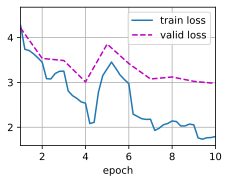

In [16]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    finetune_net.classifier = nn.Sequential(nn.Dropout(0.5),                                  # Add dropout
                                            nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 120))
    if devices:
        finetune_net = finetune_net.to(devices[0])
 
    # Freeze the some layers of the feature extraction model
    ct = 0
    for param in finetune_net.features.parameters():
        ct += 1
        if ct < 7:   # let's unfreeze last 2 layers
            param.requires_grad = False
        else:
            param.requires_grad = True
    
    return finetune_net

# Change hyperparameters
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-3, 1e-4   # Slightly higher initial learning rate
lr_period, lr_decay, net = 3, 0.7, get_net(devices)                # Modify decay parameters
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

### **6.3. Configuration #3**
For the next configuration:

1. Unfreezing Layers: Instead of only 6 as in the immediate prior version, 7 remain frozen and the rest of the layers are allowed to learn from the data. This moderate unfreezing should allow the model to better adapt to the new dataset since the final layers of a pre-trained model, which are most specific to the original task and dataset, might not be as useful for this task.

2. Learning Rate: The learning rate is now back to 1e-4, the same as in the original version. The increased learning rate in the last version might have caused instability in training and a higher loss, so reducing it allows for more stable and controlled learning.

3. Other tweaks such as dropout are kept.

The results are train loss: 0.130, valid loss: 2.299. In this version, only the layers after the 7th one are unfrozen, instead of after the 6th one as in the previous version. The first few layers in ResNet-34 typically identify general, lower-level features applicable to a wide variety of tasks. Not updating these parameters could help retain this general information. If the dog breed task has similar basic features as those in the pre-training task on ImageNet, keeping the first few layers frozen would be beneficial. 

However validation loss still indicates an overfitting problem.

train loss 0.130, valid loss 2.299
23.8 examples/sec on []


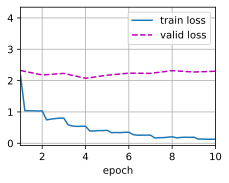

In [17]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    finetune_net.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(1000, 256),
        nn.ReLU(),
        nn.Linear(256, 120)
    )
    if devices:
        finetune_net = finetune_net.to(devices[0])
    
    ct = 0
    for name, child in finetune_net.features.named_children():
        ct += 1
        if ct < 8:  # freeze all layers except the last one
            for param in child.parameters():
                param.requires_grad = False
    return finetune_net

# Change hyperparameters
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4 # Revert learning rate
lr_period, lr_decay, net = 3, 0.7, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

### **6.4. Configuration #4**
For the next configuration:

1. ResNet model changed from ResNet-34 to ResNet-50. This should improve results but will take much more computational power

2. Number of layers of ResNet50 that are set to be untrainable - only the first 6 layers are frozen, meaning the majority of the ResNet50 layers are allowed to update their weights during training. While the number has decreased compared to the previous versions (where the first 7 layers were frozen), keep in mind that ResNet50 has more layers than ResNet34, so in reality, a larger portion of the entire network is being trained.


Training loss: 0.079, Validation loss: 2.207. 

Overfitting is still an issue but better training loss indicates that with ResNet-50, the model has learned to fit the data more effectively.

train loss 0.079, valid loss 2.207
8.4 examples/sec on []


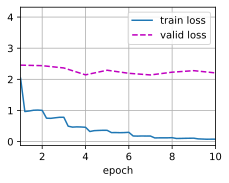

In [21]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet50(pretrained=True)  # use ResNet50
    finetune_net.classifier = nn.Sequential(
        nn.Dropout(0.5), 
        nn.Linear(1000, 256), 
        nn.ReLU(), 
        nn.Linear(256, 120)
    )
    if devices:
        finetune_net = finetune_net.to(devices[0])

    ct = 0
    # Freeze all the layers in the beginning, then unfreeze the last 3
    for name, child in finetune_net.features.named_children():
        ct += 1
        if ct < 7:
            for param in child.parameters():
                param.requires_grad = False
    return finetune_net

# Keep the previous parameters
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 3, 0.7, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

### **6.5. Configuration #5**
For the next configuration, several modifications have been made to improve performance and prevent overfitting:

1. Include a batch normalization layer at the beginning and end of the fully connected output layers and an additional fully connected layer (Linear layer). This extra layer could provide a better abstraction of the data.

2. All parameters in the ResNet50 pre-trained model are now frozen. This means the ResNet50 base is used for feature extraction only and all learning happens in the output network. If the dataset is very similar to the pre-trained base model's dataset (ImageNet), this should yield better results.

3. The optimization algorithm has been changed from SGD to RMSprop. RMSprop adapts the learning rate for each weight, which can potentially lead to faster convergence and improved performance, especially where the optimal solution involves infrequent but highly informative updates.

Training loss: 0.412, Valid loss: 1.139. Performance has degraded with increased training loss with and a decrease to the overfitting issue. Adjustments have improved the model's ability to generalize to unseen data, however at the cost of appear model's fit to the training data.

train loss 0.412, valid loss 1.139
14.2 examples/sec on []


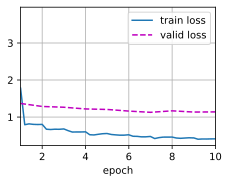

In [24]:
import torch.optim as optim

def get_net(devices):
    finetune_net = torchvision.models.resnet50(pretrained=True)
    for param in finetune_net.parameters():
        param.requires_grad = False  # freeze all ResNet layers

    # Replace the final fully-connected layer with our custom layers
    finetune_net.fc = nn.Sequential(
        nn.BatchNorm1d(2048),
        nn.Dropout(0.5),
        nn.Linear(2048, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.5),
        nn.Linear(1024, 120)         
    )
    if devices:
        finetune_net = finetune_net.to(devices[0])
    return finetune_net

# Changed SGD optimizer to RMSProp
optimizer = optim.RMSprop((param for param in net.parameters() if param.requires_grad), lr=lr, momentum=0.9, weight_decay=wd)

# Keep the previous parameters
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 3, 0.7, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

### **6.6. Configuration #6**
For the next configuration:

1. The previous version had batch normalization layers in the additional classifier. In this version, these layers have been removed, simplifying the architecture. The batch normalization layers standardize the inputs and add two learnable parameters (scale and shift). Removing these might help in reducing the complexity of the model and focus on traditional regularization.

2. The new classifier has three fully-connected layers, each followed by a ReLU activation function except for the last one. The first one reduces the dimension of the output from 2048 (the output dimension of ResNet50) to 1024, the second reduces this further to 256 and the last one finally produces the output. Dropout regularization is still here, to prevent overfitting.

3. The optimizer has now changed to Adam. The Adam optimization algorithm uses a combination of two methods that perform well: RMSProp and Stochastic Gradient Descent with Momentum. It can often be better suited to deep learning applications involving large data and parameter spaces.

Training loss: 1.082, Valid loss: 2.156. A significant degradation in performance with only a negligible change in overfitting. Perhaps the switch to Adam cause some instability in training as Adam tends to be more sensitive to the setting of the learning rate than SGD or RMSProp. 

In [ ]:
def get_net(devices):
    finetune_net = torchvision.models.resnet50(pretrained=True)  # Use ResNet50
    for param in finetune_net.parameters():
        param.requires_grad = False  # freeze all ResNet layers

    # Replace the final fully-connected layer with our custom layers
    finetune_net.fc = nn.Sequential(
        nn.Linear(2048, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 120)   # change num_classes to your actual number of classes
    )

    # Move the model to devices if devices is not empty
    if devices:
        finetune_net = finetune_net.to(devices[0])
    return finetune_net

# Use Adam optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Keep the previous parameters
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 3, 0.7, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

# **END OF NOTEBOOK**